# Historical ROA Analysis
### Data Engineering Capstone Project

#### Project Summary
On the Internet, networks announce their prefixes (IP address ranges) to other networks through
the BGP protocol. However, based on an external database called RPKI containing ROAs, those announcements can be tagged as **valid**, **invalid** or **not-found**.
Whenever the announcement of a prefix is tagged as invalid, networks receiving those announcements will drop these prefixes if they are performing Route Origin Validation (ROV). 
The aim of this project is to capture the BGP propagation time following changes in the RPKI.
* t1 = time of the creation of a ROA
* t2 = time of withdrawal seen in BGP
* t_d = t2 - t1 (delta between t2 and t1 and corresponds to the propagation time)


The project follows the follow steps:
* A: Scope the Project and Gather Data
* B: Explore and Assess the Data
* C: Define the Data Model
* D: Run ETL to Model the Data
* E: Complete Project Write Up

In [1]:
# Do all imports and installs here
# Need to install bgpstream first, here for more details: https://bgpstream.caida.org/docs/install/bgpstream
!bash install.sh 

Get:1 http://security.ubuntu.com/ubuntu xenial-security InRelease [99.8 kB]
Hit:2 http://ppa.launchpad.net/ubuntu-toolchain-r/test/ubuntu xenial InRelease 
Get:3 https://cli-assets.heroku.com/apt ./ InRelease [2,895 B]           
Hit:4 http://archive.ubuntu.com/ubuntu xenial InRelease                  
Get:6 http://archive.ubuntu.com/ubuntu xenial-updates InRelease [99.8 kB]
Get:7 https://dl.cloudsmith.io/public/wand/libwandio/deb/ubuntu xenial InRelease [5,217 B]
Hit:8 https://pkg.caida.org/os/ubuntu xenial InRelease         
Hit:9 https://deb.nodesource.com/node_11.x xenial InRelease    
Err:3 https://cli-assets.heroku.com/apt ./ InRelease           
  The following signatures couldn't be verified because the public key is not available: NO_PUBKEY 6DB5542C356545CF
Get:10 http://archive.ubuntu.com/ubuntu xenial-backports InRelease [97.4 kB]
Hit:5 https://downloads.apache.org/cassandra/debian 311x InRelease
Fetched 305 kB in 1s (260 kB/s)
Reading package lists... Done
W: An error occur

In [1]:
import config
from rib import RIB
from rov import ROV
from roa import ROA
from bgp import BGP
from datetime import date, datetime, timedelta
import pandas as pd
import cassandra
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

#### Creating a Cluster

In [6]:
# This should make a connection to a Cassandra instance your local machine 
# (127.0.0.1)

from cassandra.cluster import Cluster
cluster = Cluster()

# To establish connection and begin executing queries, need a session
session = cluster.connect()

#### Create keyspace

In [7]:
# TO-DO: Create a Keyspace
session.execute("""
    CREATE KEYSPACE IF NOT EXISTS udacity 
    WITH REPLICATION = 
    { 'class' : 'SimpleStrategy', 'replication_factor' : 1 }""")

#### Set keyspace

In [8]:
# TO-DO: Set KEYSPACE to the keyspace specified above
session.set_keyspace('udacity')

### A. Scope the Project and Gather Data
The data gathering is done in multiple steps


#### Describe and Gather Data 
Describe the data sets you're using. Where did it come from? What type of information is included? 


Input datasets:
As input, we have the RIB files from [Routeviews](http://archive.routeviews.org/bgpdata/2018.01/RIBS/rib.20180101.0000.bz2)

We will take data every month from 2018-01-01 till now.

For each RIB file we will extract the prefixes using `pybgpstream` and origin AS and run Route Origin validation using `rov`.

#### Step 1: Download a RIB file
First we download and extract **prefix** and **origin ASN** information from a RIB file. 
We take only the unique values (prefix, origin_as) and drop all duplicates.

In [4]:
# Read in the data here 
url = 'http://archive.routeviews.org/route-views.bdix/bgpdata/2022.01/RIBS/rib.20220101.0000.bz2'

rib = RIB()
file = rib.retrieveFile(url)
df = rib.parseMRT(config.TMP_DIR + file)

In [5]:
print(df.shape)

(5279, 2)


In [22]:
query = "CREATE TABLE IF NOT EXISTS rib"
query = query + "(prefix text, origin_asn int, PRIMARY KEY (prefix, origin_asn))"
session.execute(query)

query = "INSERT INTO rib (prefix, origin_asn) VALUES (?,?)"
prepared = session.prepare(query)

In [23]:
for index, row in df.iterrows():
    session.execute(prepared, (row['prefix'],int(row['origin_asn'])))

#### Step 2: Validate the prefixes using RPKI
Once we have a list of prefixes from the RIB, we need to validate them. This step adds an additional column "status"
to the dataframe and insert a status ("Valid", "Not Found", "Invalid", "Invalid;more-specific". For the purpose of 
this project, we are interested in the "Invalid" and "Invalid;more-specific" only.

The ROV class, runs the RPKI validation and tags each row. We then filter out the invalid only for step 3.

In [24]:
##extract date
d_string = url.split("/")[-1].split('.')[1]
date = datetime.strptime(d_string, '%Y%m%d')

rpki_dir = config.DEFAULT_RPKI_DIR 
##Compute RPKI archive URLs

rpki_url = []
rpki_dir += "/" + "/".join([str(date.year), str(date.month), str(date.day)]) + '/' 
for url in config.RPKI_ARCHIVE_URLS:
    rpki_url.append( url.format(year=int(date.year), month=int(date.month), day=int(date.day)) )
    

rov = ROV(rpki_url, rpki_dir=rpki_dir)
rov.download_databases(False)
rov.load_rpki()

df['status'] = df.apply(rov.check, axis=1)
df = df.loc[df.status.str.contains('Invalid')]

https://ftp.ripe.net/ripe/rpki/afrinic.tal/2022/01/01/roas.csv


Downloading: https://ftp.ripe.net/ripe/rpki/afrinic.tal/2022/01/01/roas.csv


/root/.cache/rov/db/rpki//2022/1/1/afrinic.csv
https://ftp.ripe.net/ripe/rpki/apnic.tal/2022/01/01/roas.csv


Downloading: https://ftp.ripe.net/ripe/rpki/apnic.tal/2022/01/01/roas.csv


/root/.cache/rov/db/rpki//2022/1/1/apnic.csv
https://ftp.ripe.net/ripe/rpki/arin.tal/2022/01/01/roas.csv


Downloading: https://ftp.ripe.net/ripe/rpki/arin.tal/2022/01/01/roas.csv


/root/.cache/rov/db/rpki//2022/1/1/arin.csv
https://ftp.ripe.net/ripe/rpki/lacnic.tal/2022/01/01/roas.csv


Downloading: https://ftp.ripe.net/ripe/rpki/lacnic.tal/2022/01/01/roas.csv


/root/.cache/rov/db/rpki//2022/1/1/lacnic.csv
https://ftp.ripe.net/ripe/rpki/ripencc.tal/2022/01/01/roas.csv


Downloading: https://ftp.ripe.net/ripe/rpki/ripencc.tal/2022/01/01/roas.csv


/root/.cache/rov/db/rpki//2022/1/1/ripencc.csv


Loading: /root/.cache/rov/db/rpki//2022/1/1/ripencc.csv
Loading: /root/.cache/rov/db/rpki//2022/1/1/afrinic.csv
Loading: /root/.cache/rov/db/rpki//2022/1/1/lacnic.csv
Loading: /root/.cache/rov/db/rpki//2022/1/1/apnic.csv
Loading: /root/.cache/rov/db/rpki//2022/1/1/arin.csv


In [27]:
query = "CREATE TABLE IF NOT EXISTS roa"
query = query + "(prefix text, origin_asn int, status text, PRIMARY KEY (prefix, origin_asn))"
session.execute(query)

query = "INSERT INTO rov (prefix, origin_asn, status) VALUES (?,?,?)"
prepared = session.prepare(query)

In [ ]:
for index, row in df.iterrows():
    session.execute(prepared, (row['prefix'],int(row['origin_asn'])))

#### Step 3: Get the corresponding ROAs for the invalid

In [7]:
roa = ROA()

#define a data model for the ROA dataframe
df_roas = pd.DataFrame(columns={'prefix','tal','roa_creation_time'})

for index, row in df.iterrows():
    res = roa.getROACreationDates(row['prefix'])

    if not res:
        continue

    timestamps = res['dates']
    tal = res['tal']
    prefix = row['prefix']
    #print(prefix, tal, timestamps)

    for t in timestamps:
        #df_roas.loc[df_roas.shape[0]] = [prefix, tal, t]
        df_roas = df_roas.append({'prefix':prefix,'tal':tal,'roa_creation_time':t},ignore_index=True)

In [8]:
#filter out roas with creation time < 2018
df_roas = df_roas.loc[df_roas.roa_creation_time > '2018-01-01']

In [9]:
# take a sample (n=20) from each TAL, if it fails just take everything
df_arin = df_roas.loc[df_roas.tal == 'arin']
df_apnic = df_roas.loc[df_roas.tal == 'apnic']
df_ripe = df_roas.loc[df_roas.tal == 'ripencc']
df_lacnic = df_roas.loc[df_roas.tal == 'lacnic']
df_afrinic = df_roas.loc[df_roas.tal == 'afrinic']

try:
    df_roas = pd.concat([df_arin.sample(n=20), df_apnic.sample(n=20), df_ripe.sample(n=20), df_lacnic.sample(n=20), df_afrinic.sample(n=20)], ignore_index=True)
except Exception as e:
    pass

#### Step 4: Retrieve the time between the creation of a ROA and when a withdraw message appears in BGP

#### Create table to store the data

In [13]:
query = "CREATE TABLE IF NOT EXISTS roa_timing "
query = query + "(prefix text, tal text, peer_ip inet, roa_create_time timestamp, withdrawal_time timestamp, delta float, PRIMARY KEY (prefix, peer_ip))"
session.execute(query)

In [14]:
df_roas

,tal,roa_creation_time,prefix
1,lacnic,2021-01-02T03:00:00,181.214.155.0/24
2,lacnic,2020-11-25T02:00:00,181.214.155.0/24
3,ripencc,2020-07-21T08:32:14,194.133.122.0/24
4,ripencc,2021-01-01T07:48:03,194.133.122.0/24
5,ripencc,2022-01-01T09:03:21,194.133.122.0/24
6,ripencc,2020-02-24T18:05:18,194.133.159.0/24
7,ripencc,2022-01-01T09:03:21,194.133.159.0/24
8,ripencc,2022-01-01T09:03:21,194.133.159.0/24


In [15]:
#### /!\/!\/!\/!\/!\this takes a lot of time

bgp = BGP()
for index, row in df_roas.iterrows():
    prefix = row['prefix']
    t = row['roa_creation_time']
    tal = row['tal']
    
    elements = {}
    
    elements = bgp.extractWithdrawalTimePyBGPStream(prefix, t, 1, True)

    for peer_ip, wtime in elements.items():
        roa_create_time = datetime.strptime(t, '%Y-%m-%dT%H:%M:%S')
        withdrawal_time = datetime.fromtimestamp(int(wtime))
        delta = (withdrawal_time - roa_create_time).seconds
        
        query = "INSERT INTO roa_timing (prefix, tal, peer_ip, roa_create_time, withdrawal_time, delta)"
        query = query + "VALUES (%s, %s, %s, %s, %s, %s)"
        print(query)
        session.execute(query, (prefix, tal, peer_ip, roa_create_time, withdrawal_time, delta))

181.214.155.0/24 2021-01-02T03:00:00 lacnic
181.214.155.0/24 2021-01-02 03:00:00 2021-01-02 04:00:00
23.129.32.61,1609558111.0
INSERT INTO roa_timing (prefix, tal, peer_ip, roa_create_time, withdrawal_time, delta)VALUES (%s, %s, %s, %s, %s, %s)
181.214.155.0/24 2020-11-25T02:00:00 lacnic
181.214.155.0/24 2020-11-25 02:00:00 2020-11-25 03:00:00
194.133.122.0/24 2020-07-21T08:32:14 ripencc
194.133.122.0/24 2020-07-21 08:32:14 2020-07-21 09:32:14
194.133.122.0/24 2021-01-01T07:48:03 ripencc
194.133.122.0/24 2021-01-01 07:48:03 2021-01-01 08:48:03
194.133.122.0/24 2022-01-01T09:03:21 ripencc
194.133.122.0/24 2022-01-01 09:03:21 2022-01-01 10:03:21
194.133.159.0/24 2020-02-24T18:05:18 ripencc
194.133.159.0/24 2020-02-24 18:05:18 2020-02-24 19:05:18
194.133.159.0/24 2022-01-01T09:03:21 ripencc
194.133.159.0/24 2022-01-01 09:03:21 2022-01-01 10:03:21
194.133.159.0/24 2022-01-01T09:03:21 ripencc
194.133.159.0/24 2022-01-01 09:03:21 2022-01-01 10:03:21


In [16]:
## TO-DO: Add in the SELECT statement to verify the data was entered into the table
query = "SELECT prefix, tal, peer_ip, roa_create_time, withdrawal_time, delta from roa_timing"
rows = session.execute(query)
for row in rows:
    print(row.prefix, row.tal, row.peer_ip, row.roa_create_time, row.withdrawal_time, row.delta)

181.214.155.0/24 lacnic 23.129.32.61 2021-01-02 03:00:00 2021-01-02 03:28:31 1711.0


### Step 2: Explore and Assess the Data
The above shows the data collection process. However for the sake of this exercise and because the data collection process is lengthy, we will use data that has been collected already.

#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

In [22]:
# Performing cleaning tasks here
df = pd.read_csv('data/results.csv', header='infer', dtype={'delta':np.int32}, parse_dates=['roa_create_time','withdrawal_time'], skip_blank_lines=True)
df['delta_min'] = df.delta/60
df.head()

,prefix,tal,peer_ip,roa_create_time,withdrawal_time,delta,delta_min
0,2803:ffe0::/32,lacnic,2001:7f8:1::a504:7957:1,2021-03-24 03:00:00,2021-03-24 03:04:31,271,4.516667
1,2803:ffe0::/32,lacnic,2001:7f8:1::a503:8880:1,2021-03-24 03:00:00,2021-03-24 03:04:47,287,4.783333
2,2803:ffe0::/32,lacnic,2001:7f8:1::a500:293:1,2021-03-24 03:00:00,2021-03-24 03:05:06,306,5.100000
3,2803:ffe0::/32,lacnic,2001:504:40:108::1:11,2021-03-24 03:00:00,2021-03-24 03:04:29,269,4.483333
4,2803:ffe0::/32,lacnic,2001:504:40:108::1:115,2021-03-24 03:00:00,2021-03-24 03:04:46,286,4.766667


/opt/conda/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


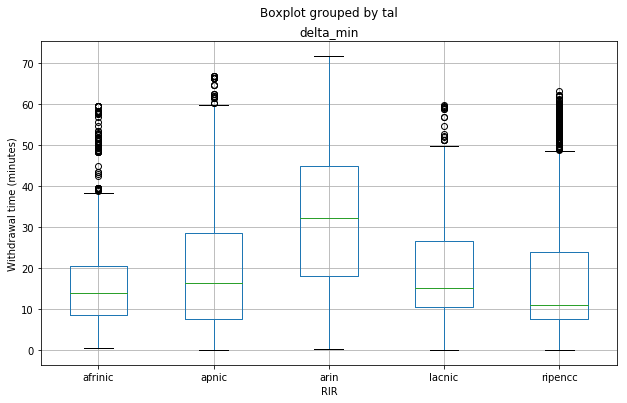

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
df.boxplot(by ='tal', column =['delta_min'], grid = False, ax=ax)

ax.set_xlabel("RIR")
ax.set_ylabel("Withdrawal time (minutes)")
ax.grid(True)

plt.show()